# PHYS20762 - Project - Monte Carlo Techniques
# Penetration of Neutrons Through Shielding

Tobias Fox<br>
University of Manchester<br>
May 2022

This project aims to use Monte Carlo techniques to simulate the random nature of neutron penetration through a shield of different materials and thicknesses. Monte Carlo techniques are used to replicate the random nature of a large number of particles travelling through a material.

The random nature of particles in the system is determined using the in-built function numpy.random.uniform. To prove the random nature of the function and uniformity, a series of plots are produced using this function to generate random numbers in 1D and 3D.

Next, a random number generator is used to produce sample data for an exponential distribution of length. This is used in the absence of scattering to prove that the characteristic attenuation length, without scattering, for water is around 45 cm.  Using this length distribution, a 3D plot of particles within each material is produced using spherical unit vectors, this is done to visually show that the particles produced have a uniform length distribution.

Then, the neutron transmission, reflection and absorption of each material is calculated using a simulation of neutrons passing through the material. This replicates the random nature of particles in a material, with the processes it may encourage, absorption, scattering, transmission or reflection. This simulation uses this length distribution in the section before with calculation for the probability of absorption and total mean free path of each material to simulate the path of a neutron in a material.

Finally, the transmission of neutrons passing from two touch materials is calculated. This is done using a simulation of neutrons that uses the woodcock method to estimate the path of the neutrons passing through both materials and crossing the boundaries. This again uses the length distribution with the probability of absorption and total mean free path of each material to simulate the path of a neutron in each material.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#Defines the thermal neutron data.

AVOGADRO_CONSTANT = 6.022 * 10 ** 23 #mol-1

#Stored the thermal neutron data of each material in a dictionary, this makes it easier to call the data further on in the code.

water = {"name": "water", "density": 1.00, "molar_mass": 18.01528, "absorption": 0.6652 * 10 ** -24,
         "scattering": 103.0 * 10 ** -24}
lead = {"name": "lead", "density": 11.35, "molar_mass": 207.2, "absorption": 0.158 * 10 ** -24,
        "scattering": 11.221 * 10 ** -24}
graphite = {"name": "graphite", "density": 1.67, "molar_mass": 12.011, "absorption": 0.0045 * 10 ** -24,
            "scattering":  4.74 * 10 ** -24}
vacuum = {"name": "vacuum", "density": 0, "molar_mass": 0, "absorption": 0,
            "scattering": 0}

# 1D Random Uniform Numbers

For this project, the random number generator used must produce a uniform spread of numbers. This section aims to show that the random number generator np.random.uniform produces a random array of numbers.

To show the uniformity of the random numbers produced, several lines containing an increasing amount of random numbers are shown graphically. If the numbers generated are uniform, as the number of points is built up, the line should fill in evenly leaving fewer gaps on the line, showing no clumping of the numbers. A range between 10 and 10000 points is chosen to show the results.

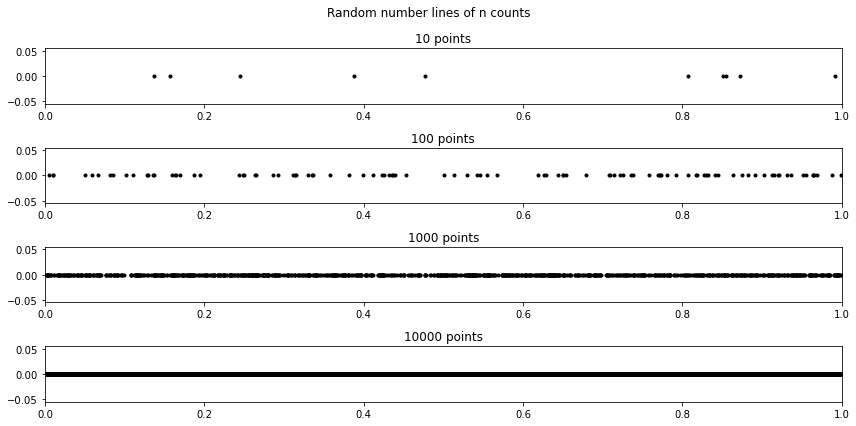

In [2]:
def random_number_line():
    
    number_of_random_points = 10 ** np.arange(1, 5)
    
    #Plots a number line with the randomly generated points.

    fig = plt.figure(figsize=(12, 6))
    axes = fig.subplots(len(number_of_random_points), 1)
    
    fig.suptitle("Random number lines of n counts")
    
    for iterations, ax in enumerate(axes):
        
        #Generates random values between 0 and 1.
        
        random_number_array = np.random.uniform(0, 1, number_of_random_points[iterations])
        
        y = np.linspace(0, 0, number_of_random_points[iterations])
        ax.set_title(str(number_of_random_points[iterations])+" points")
        ax.plot(random_number_array, y,'k.')
        ax.set_xlim(0, 1)
        
    plt.tight_layout()  
    plt.show()
    
random_number_line()

The graphs above show that as the number of random points increases, they are spread evenly over the range of 0 to 1 as there is no large clumping of data points, especially when the count is increased to 1000 or 10000. This shows that the points are uniform over the chosen range.

# 3D Random Uniform Numbers

Different types of random number generators have their advantages and disadvantages. As said above, the random number generator must be uniform and the uniformity was looked at in a 1D space. However, is it important for this uniformity to hold in 3D space too, as particles in real-life travel through 3D space. Some sampling processes at first can seem uniform, however, in 3D space as the plots are rotated, the number distributions lie on hyperplanes. This means there is a correlation of points, this can course simulations to become non-uniform which is bad for a simulation which requires uniformly random numbers. This is called the spectral problem.

To show that there is no spectral problem with the generator used, a set of 3D vectors is produced. This is done by producing a random number between -1 and 1 for the x, y and z coordinates of each vector. By discarding any vectors with a radius larger than 1, a sphere of uniform random vectors is produced. Rotating this sphere it can be seen whether or not there are visually noticeable hyperplanes.

In [3]:
def generate_3d_vectors(number_of_points):
    
    #Generates random values between -1 and 1 for the x, y and z components of the vectors.
    
    random_number_array_3d = np.random.uniform(-1, 1, (number_of_points, 3))
    
    #Calculates the radius of each vector, which is each row in the array and deletes any which radius is greater than 1.
    
    radius = np.sqrt(np.square(random_number_array_3d).sum(axis=1))
    random_number_array_3d = np.delete(random_number_array_3d, np.where(radius>1), axis=0)
    
    #Plots a 3D graph of the randomly generated vectors with a radius less than 1.

    fig = plt.figure(figsize=(8, 6))
    ax = fig.gca(projection='3d')
    
    ax.scatter(random_number_array_3d[:, 0], random_number_array_3d[:, 1], random_number_array_3d[:, 2], marker='^')
    ax.set_title("3D random vectors")
    
    plt.tight_layout()
    plt.show()

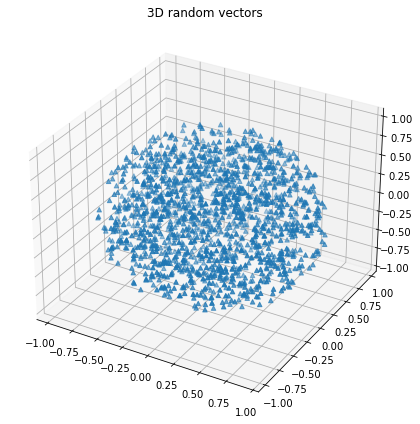

In [4]:
count = 3000
generate_3d_vectors(3000)

Using %matplotlib notebook to rotate the plot, it can be seen that there are no visible hyperplanes in this plot of random numbers. Again, this confirms that the random number generator produces a uniform set of random numbers.

# Sample of an Exponential Distribution

For the neutron radiation, the length distribution is an exponentially decaying function which is shown with the equation P[x] = exp(-x / lambda), lambda being the mean free path. To generate this exponentially decaying length distribution, we need to take the inverse of the cumulative distribution which is s_i = - lambda * log(u_i), u_i being a randomly generated number. 

To show that the distribution is exponentially decaying for a fixed set of random numbers, a histogram is used to show the mean and std of a set of repeats which produce random numbers according to the inverse of the CDF for a count of 1000 particles. From this histogram, the log of the mean is taken and plotted as a linear fit, this fit is determined using polyfit. The gradient of this linear fit should be - 1 / lambda if the distribution produced fits the exponential function of the mean free path.

This is used to simulate the length distribution of neutrons in water, in the absence of scattering. The mean free path is calculated from the properties of the material and is compared to the resulting gradient of the graph produced.

In [8]:
def random(count):
    
    #Defines a function that will generate a random number between 0 and 1 and produces an array the size of the count.
    
    return np.random.uniform(0, 1, count)

In [9]:
def exponential_function(material, n_a=AVOGADRO_CONSTANT):
    
    #Calculates the mean free path of neutrons in the material, ignoring scattering.
    
    n = (material["density"] * n_a) / material["molar_mass"] #cm^-3
    lambda_a = 1 / (n * material["absorption"]) #cm
    
    #Sets the number of times the process will repeat to calculate the mean results. It also sets the count, bin count and
    #range of the histogram.
    
    repeats = 10
    count, bin_count, x_max = 1000, 33, 300
    width = x_max / bin_count
    
    height_array = np.empty((0, bin_count))  
    
    #Generates an array of uniformly random numbers between 0 and 1, then this random number is logarithmically distributed 
    #using the mean free path, ignoring scattering. for the given material. This distribution is then turned into a histogram
    #and the data are stored in an array. This is repeated for the given amount of times and stored all the data in an array. 
    
    for i in range(repeats):

        array = random(count)
        s_i = - lambda_a * np.log(array)

        hist, bins = np.histogram(s_i, bin_count, range=(0, x_max))
        height_array = np.vstack((height_array, hist))
    
    #Calculates the mean and error of the histogram data and calculates the midpoints of each bin.
    
    x = np.linspace((width)*0.5, x_max-(width)*0.5, bin_count).reshape(-1, 1)
    hist_data = np.hstack((x, np.mean(height_array, axis=0).reshape(-1, 1),
                           np.std(height_array, axis=0).reshape(-1, 1)))
    
    #Removes any zero values from the histogram data to remove any zero division errors.
    #Takes the log of the histogram mean and calculates the percentage uncertainty of the data (the percentage uncertainty
    #is equal to the absolute uncertainty of logarithmic data).
    #Uses poly fit to calculate the linear relationship of the logarithmic data, using a weighting of the reciprocal of the 
    #error, this is so the weighting is reduced for data points with a larger error range.
           
    scatter_data = np.delete(hist_data, np.where(hist_data[:, 1]==0), axis=0)
    scatter_data[:, 2] = scatter_data[:, 2] / scatter_data[:, 1]
    scatter_data[:, 1] = np.log(scatter_data[:, 1])    
    coeff = np.polyfit(scatter_data[:, 0], scatter_data[:, 1], 1, w=1/scatter_data[:, 2], cov=True)
    
    return hist_data, scatter_data, width, coeff

In [10]:
def radius_plotter(material):
    
    hist_data, scatter_data, width, coeff = exponential_function(material)
    
    #Plots scatter and histogram graph
    
    fig = plt.figure(figsize=(7, 10))
    histogram_ax = fig.add_subplot(211)
    scatter_ax = fig.add_subplot(212)
    
    #Plots a histogram using the mean of the data from the logarithmic distribution and plots the data points with
    #a line of best fit using the coefficients of the polyfit in an exponential distribution.
    
    histogram_ax.bar(hist_data[:, 0], hist_data[:, 1], width)    
    histogram_ax.errorbar(hist_data[:, 0], hist_data[:, 1], hist_data[:, 2], color='k', fmt='o')  
    histogram_ax.plot(hist_data[:, 0], np.exp(hist_data[:, 0]*coeff[0][0]+coeff[0][1]), 'r')
    histogram_ax.set_xlabel(r"R$_i$ (cm)")
    histogram_ax.set_ylabel(r"N$_R$")
    histogram_ax.set_title("Inverse CDF Exponential Distribution")
    histogram_ax.grid()
    
    #Plots the log of the histogram data and plots a line of best fit using the coefficients from the polyfit with 
    #a linear relationship.
        
    scatter_ax.errorbar(scatter_data[:, 0], scatter_data[:, 1], scatter_data[:, 2], color='k', fmt='o')    
    scatter_ax.plot(scatter_data[:, 0], coeff[0][0]*scatter_data[:, 0]+coeff[0][1])
    scatter_ax.set_xlabel(r"R$_i$ (cm)")
    scatter_ax.set_ylabel(r"$log(N_R)$")
    scatter_ax.grid()
    
    plt.tight_layout()
    plt.show()
    
    #Calculates and outputs the mean free path for the material.
    
    lambda_cal = -1 / coeff[0][0]
    lambda_cal_std = abs(np.sqrt(coeff[1][0][0])) * lambda_cal
    
    print("lambda = {0:3.2f} ± {1:1.2f} cm".format(lambda_cal, lambda_cal_std))

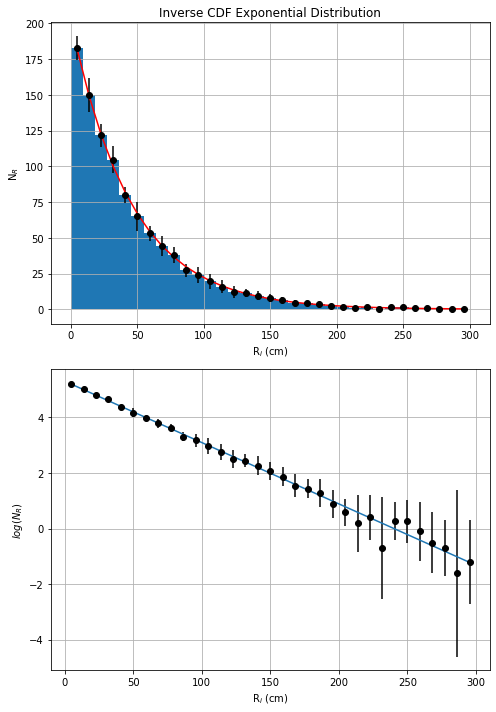

lambda = 45.28 ± 0.01 cm


In [11]:
radius_plotter(water)

From the first plot of the data in the form of a histogram, the height of each bin decreases as r_i, the radius, increases. This is what is expected from the exponential distribution. On the histogram the mean height and std of each bin and a line of best fit are plotted, the line of best fit was calculated using the exponential of the gradient calculated in the log(N_R) graph.

The second plot of the log mean from the histogram shows a linear relationship between the radius and the log of the count, this is to be expected when taking the log of an exponentially decaying distribution. On the graph a line of best fit is drawn, this is fitted using polyfit and the gradient of the line is used to calculate the mean free path of water.

The mean free path calculates is close to the expected answer of 45 cm.

# Isotropic unit vectors

When simulating neutrons within a material, the path of the neutron is broken down into steps. In each step, the particle will either be absorbed or scattered. If the neutron is scattered it will move a distance which is generated using a length distribution above but also move in a random direction.

Each step must be isotropic in direction. To do this the length distribution is given a direction using polar coordinates which are generated using random numbers. However, when using these random numbers with polar coordinates, the points can clump at the poles which is not an isotropic distribution, which is required. To eliminate these poles a theta angle is picked by taking acos(1 - 2 * u_i), where u_i is a random number between 0 and 1, this gives a lower concentration of theta angles close to either 0 or 1. This reduces the high concentration of points around the poles. A phi angle is generated using the random number generator between 0 and 2pi.

To show that these directions are isotropic, a 3D graph is plotted with vectors which have a length of 1 and a random direction. If they are isotropic, a uniform distribution will be seen with no clumping around the poles.

In [12]:
def isotropic_unit_vectors(count, radius):
    
    #Uses random numbers to calculate the angle of the spherical vectors, phi is calculated using a random number between
    #0 and 2*pi. Theta uses a random number between 0 and 1 and calculates using acos(1 - 2*theta), this is done to stop
    #clumping of vectors around the poles to increase the uniformity of the random distribution.
    
    theta_angles = np.arccos(1 - 2 * random(count))
    phi_angles = np.random.uniform(0, 2*np.pi, count)
    
    vectors = np.empty((0, 3))
    
    #Calculates a 3d spherical vector, using a given radius and a random direction, determined using the random angles
    #set above.
    
    for index, theta_angle in enumerate(theta_angles):
    
        temp = ([radius[index]*np.sin(theta_angle)*np.cos(phi_angles[index]),
                 radius[index]*np.sin(theta_angle)*np.sin(phi_angles[index]),
                 radius[index]*np.cos(theta_angle)])
        vectors = np.vstack((vectors, temp))
        
    return vectors

In [13]:
def plot_3d(vectors, title):
    
    #Plots a 3D graph of the vector points.
    
    fig = plt.figure(figsize=(8, 6))
    ax = fig.gca(projection='3d')
    
    ax.scatter(vectors[:, 0], vectors[:, 1], vectors[:, 2], marker='^')
    ax.set_title(title)
    
    ax.set_xlim3d(-20, 20)
    ax.set_ylim3d(-20, 20)
    ax.set_zlim3d(-20, 20)
    
    plt.tight_layout()
    plt.show()

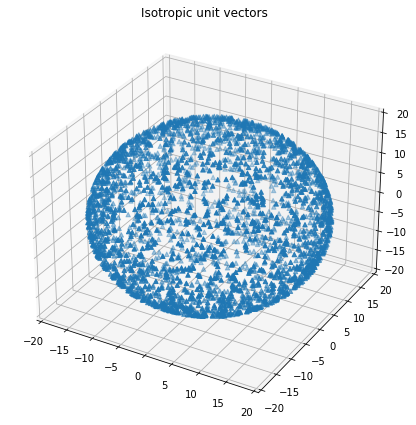

In [15]:
count = 3000
radius = np.linspace(20, 20, count)
title = "Isotropic unit vectors"

vectors = isotropic_unit_vectors(count, radius)
plot_3d(vectors, title)

From the 3D graph above, it can be seen that the vectors are in fact uniform, with no clumping around the poles.

# An Isotropic step in each material

Combining the two functions of the length distribution and the isotropic unit vectors, a simulation of an isotropic step in each material with neutron particles. Each particle takes one step in a random direction, starting from the origin. The mean free path of each material is calculated using the material properties and this assumes that absorption and scattering is occurring, however, this is just the first step so no processes occur other than a motion in a random direction. 

In [17]:
def lengths_distribution_xyz(count, material,  n_a=AVOGADRO_CONSTANT):
    
    #Calculates total mean free path from given thermal neutron data, using both the absorption and scattering data.
    
    n = (material["density"] * n_a) / material["molar_mass"] #cm^-3
    lambda_t = 1 / ((material["absorption"] + material["scattering"]) * n) #cm^-1
    
    #Generates an array of uniformly random numbers between 0 and 1, then this random number is logarithmically distributed
    #using the total mean free path for the given material.
    
    array = random(count)
    s_i = - lambda_t * np.log(array)
    
    #Uses the length distribution and gives it a direction using the isotropic_unit_vectors function.
    
    vectors = isotropic_unit_vectors(count, s_i)
    
    return vectors

An isotropic step in water.

Water has a mean free path of 0.289 cm

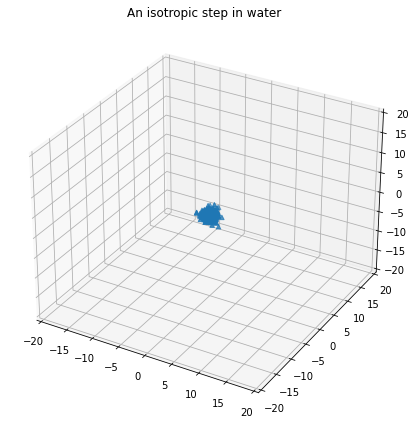

In [18]:
count = 10000
title = "An isotropic step in water"

vectors = lengths_distribution_xyz(count, water)
plot_3d(vectors, title)

An isotropic step in lead.

Lead has a mean free path of 2.664 cm

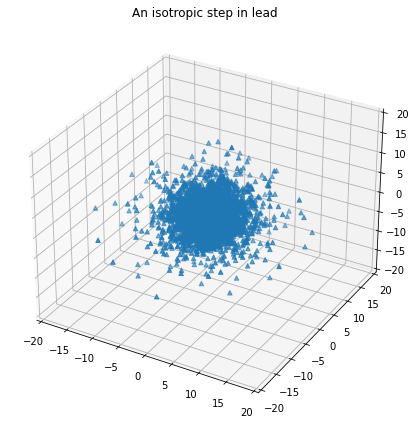

In [19]:
count = 10000
title = "An isotropic step in lead"

vectors = lengths_distribution_xyz(count, lead)
plot_3d(vectors, title)

An isotropic step in graphite.

Graphite has a mean free path of 2.517 cm

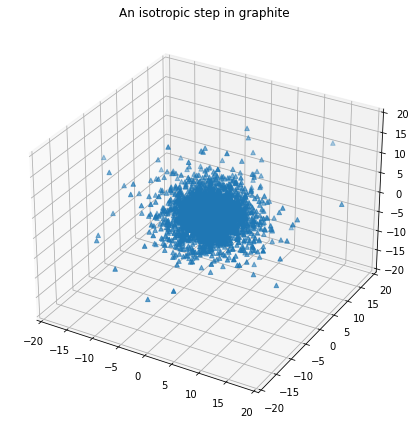

In [20]:
count = 10000
title = "An isotropic step in graphite"

vectors = lengths_distribution_xyz(count, graphite)
plot_3d(vectors, title)

Each graph shows the random nature of the neutrons in the material, it can also be seen how the length travelled by each material decreases exponentially with length. Furthermore, by plotting each graph with the same scale, it can be seen that particles, on average, travel further lead and graphite. This is to be expected as graphite and lead have much larger mean free paths than water, so neutrons will travel further in those materials before being scattered or absorbed, than in water.

# Neutrons travelling through a slab of material

This section uses the functions and knowledge above to simulate the random nature of neutrons in a given material. First, a simulation is run for a small number of particles moving in 3D space and their history is plotted, this is done to visually recognise that the particles do move in a random nature and that processes occur in their motion like scattering and absorption.

Next, a simulation is run for a larger number of particles several times, this is done to calculate the rate of transmission, absorption and scattering of neutrons in each material.

Then, the rate of transmission is calculated for a range of thickness of each material, using these results the characteristic attenuation length can be found.

In [21]:
def material_properties(material, n_a=AVOGADRO_CONSTANT):
    
    #Calculates the probability of absorption for the given material.
    
    P_A = material["absorption"] / (material["absorption"] + material["scattering"])
    
    #Calulates total mean free path for the given material.

    n = material["density"] * n_a / material["molar_mass"] #cm^-3
    lambda_t = 1 / ((material["absorption"] + material["scattering"]) * n) #cm^-1
    
    return lambda_t, P_A

Shows the neutron's path through a slab of material, this aims to show the random nature of the paths through the material and also how their paths are terminated by either absorption, transmission or reflection.

In [22]:
def neutron_paths(count, material, T):
    
    #Calculates total mean free path and probability of absorption for the given material.
    
    lambda_t, P_A = material_properties(material)
    
    #Creates empty arrays for the neutron's data and history to be stored.
    
    particle_index = np.arange(0, count)
    history = np.empty((count, 0))
    delete_index = ([])
    
    #Calculates the first step of the neutron's path, this is calculated by just using the length distribution
    #shown in the histogram section above. No direction is given because it is assumed all neutrons travel
    #in the same direction on their first step.
    
    array = random(count)
    vectors = np.hstack(((- lambda_t * np.log(array)).reshape(-1, 1), np.zeros((count, 2))))   

    #Loops through each step until no neutrons are left.
           
    while count > 0:
        
        #Saves the previous steps history.
        
        history = np.hstack((history, vectors))
        
        #Determines the index of which vector needs to be deleted based on the conditions of reflection, x vector is less
        #than zero; transmission, x vector is greater than thickness T or absorption.
        
        delete_index = np.unique(np.append(delete_index, np.where((vectors[:, 0] < 0) | (vectors[:, 0] > T))[0])).astype(int)
        continue_index = np.delete(particle_index, delete_index)
        
        count = len(continue_index)
        
        #Absorption is determined by creating a uniformly random array the size of the number of neutrons left in the
        #system and compares them to the probability of absorption. If they are less than P_A they are removed from the
        #system.
        
        delete_index = np.append(delete_index, np.where(random(len(vectors)) < P_A)[0]).astype(int)
        continue_index = np.delete(particle_index, delete_index)

        count = len(continue_index)
        
        #Adds a step to the vectors whose path hasn't been terminated, all other vectors keep their last step. When the while
        #loop is the last column of the history that contains the last step of each vector until they were terminated.
        
        vectors[continue_index, :] += lengths_distribution_xyz(count, material)
    
    return history

In [18]:
def plot_neutrons_path(count, material, T):
    
    #Calculates the history of each particle in the system.
    
    history = neutron_paths(count, material, T)
    
    #Plots a 3D graph of the neutron's path in the system.
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.gca(projection='3d')
    
    #Iterates through each particle plotting the vector points and a line of the path taken.
    
    for particle in history:
        
        ax.scatter(particle[0::3], particle[1::3], particle[2::3], marker='^')
        ax.plot(particle[0::3], particle[1::3], particle[2::3])
        
    #Calculates a mesh and plots a plane at x = 0 showing the boundary at which neutrons are reflected.
        
    y = np.linspace(np.min(history[:, 1::3]), np.max(history[:, 1::3]), 100)
    z = np.linspace(np.min(history[:, 2::3]), np.max(history[:, 2::3]), 100)
        
    yy, zz = np.meshgrid(y, z)
    x = yy * 0

    #Plot the plane.
    
    ax.plot_surface(x, yy, zz, alpha=0.3)
    ax.set_title("Path of neutrons through "+material["name"])
    
    plt.tight_layout()
    plt.show()

Plots the paths of 5 neutrons travelling through 10 cm of water.

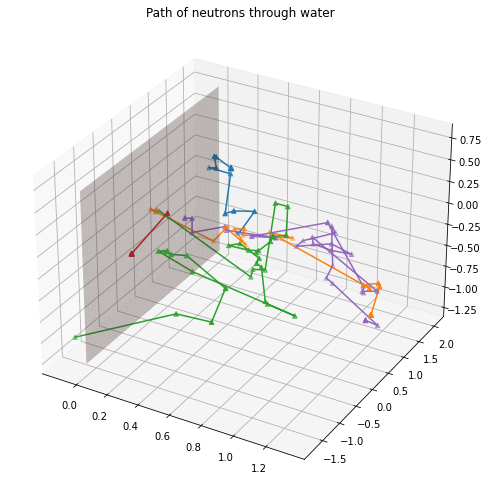

In [19]:
count = 5
material = water
thickness = 10 #cm

plot_neutrons_path(count, material, thickness)

Plots the paths of 5 neutrons travelling through 10 cm of lead.

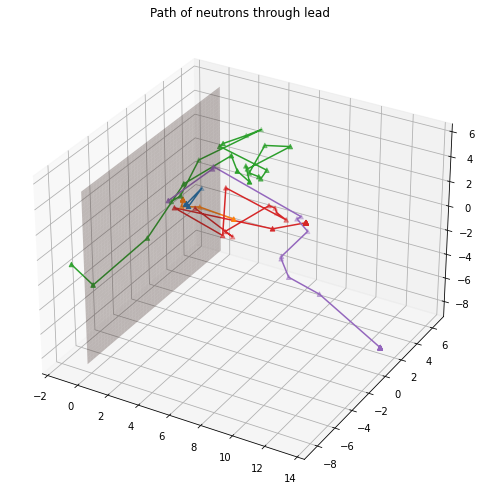

In [20]:
count = 5
material = lead
thickness = 10 #cm

plot_neutrons_path(count, material, thickness)

Plots the paths of 5 neutrons travelling through 10 cm of graphite.

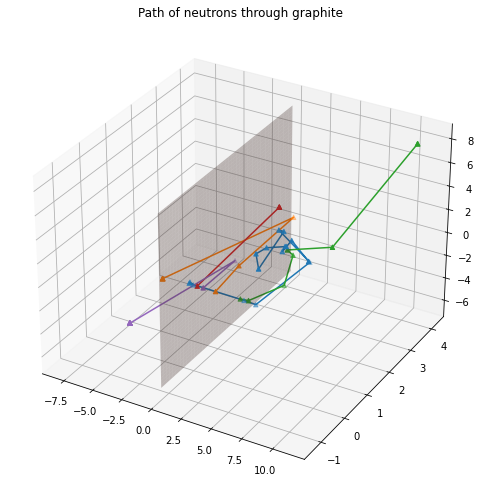

In [21]:
count = 5
material = graphite
thickness = 10 #cm

plot_neutrons_path(count, material, thickness)

Simulates the path of 10000 neutrons and calculates the rate of transmission, reflection and absorption. This process is repeated 10 times to get the mean and std of the results.

In [23]:
def lengths_distribution(count, lambda_t):
    
    #Generates an array of uniformly random numbers between 0 and 1, then this random number is logarithmically distributed
    #using the total mean free path for the given material.
    
    array = random(count)
    s_i = - lambda_t * np.log(array)
    
    #Uses the method discussed in the previous section to calculate two random theta and phi angles
       
    theta_angles = np.arccos(1 - 2 * random(count))
    phi_angles = np.random.uniform(0, 2 * np.pi, count)
    
    #Calculates a spherical vector, using a given radius and a random direction, for the vector in the x-direction.

    neutrons_position = s_i * np.sin(theta_angles) * np.cos(phi_angles)

    return neutrons_position

In [24]:
def neutron_random_walk(count, material, T):
    
    #Calculates total mean free path and probability of absorption for the given material.
    
    lambda_t, P_A = material_properties(material)
    
    #Calculates the first step of the neutron's path, this is calculated by just using the length distribution
    #shown in the histogram section above. No direction is given because it is assumed all neutrons travel
    #in the same direction on their first step.
    
    array = random(count)
    neutrons_position = - lambda_t * np.log(array)
    
    #Creates variables to sort the count of each process.
    
    transmitted_count, reflected_count, absorbed_count = 0, 0, 0
    
    #Loops through each step and process until there are no neutrons left in the system.
    
    while len(neutrons_position) > 0:
        
        #Counts how many of the positions are either greater than the thickness T, transmission, or less than 0,
        #reflection. Then it deletes them from the array as their neutrons_position has been terminated.
        
        transmitted_count += np.count_nonzero(neutrons_position > T)
        reflected_count += np.count_nonzero(neutrons_position < 0)
        neutrons_position = np.delete(neutrons_position, np.where((neutrons_position < 0) | (neutrons_position > T))[0])
        
        #Creates an array of uniformly random numbers between 0 and 1, the array is the size of the array holding
        #the neutrons neutrons_position. If the number is less than the probability of absorption it is counted and then
        #deleted from the array.
        
        absorbed  = np.where(random(len(neutrons_position)) < P_A)[0]
        absorbed_count += len(absorbed)
        neutrons_position = np.delete(neutrons_position, absorbed)
        
        #Adds a step to the array.
        
        neutrons_position += lengths_distribution(len(neutrons_position), lambda_t)

    return np.hstack((absorbed_count, reflected_count, transmitted_count))

In [25]:
def ratio_calculator(count, material, T):
    
    #Sets the number of times to repeat the calculations and creates an empty array for the results to be stored.
    
    repeats = 10
    results = np.empty((0, 3))
    
    #Repeats the calculation for the given system, storing the results in the results array.
    
    for i in range(repeats):
    
        process_count = neutron_random_walk(count, material, T)
        
        results_for_repeat =  process_count
        results = np.vstack((results, results_for_repeat))
        
    #Calculates the mean and error of the results for the repeats
        
    results_mean, results_std  = (np.mean(results, axis=0) / count) * 100, (np.std(results, axis=0) / count) * 100    
    results_error = np.empty(0)
    
    for iterations, mean in enumerate(results_mean):
        
        if mean == 0:
            results_error = np.hstack((results_error, results_std[iterations] / np.max(results[iterations])))
           
        else:
            results_error = np.hstack((results_error, results_std[iterations] / mean))
    
    return results_mean, results_error

In [25]:
def results(count, material, T):
    
    #Outputs the mean percentage and error of absorption, transmission and reflection.
    
    results_mean, results_std = ratio_calculator(count, material, thickness)
    
    print("-"*49, "\nTransmission Through A Fixed Thickness -", material["name"], "\n", "-"*47)
    print("Thickness: \t\t {0:3.2f} cm".format(T))
    print("Total Neutrons: \t", count)
    print("Neutrons Absorbed: \t {0:.2f} % ± {1:.2f} %".format(results_mean[0], results_std[0]))
    print("Neutrons Reflected: \t {0:.2f} % ± {1:.2f} %".format(results_mean[1], results_std[1]))
    print("Neutrons Transmitted: \t {0:.2f} % ± {1:.2f} %".format(results_mean[2], results_std[2]))

Water of thickness 10 cm

In [26]:
count = 10000
material = water
thickness = 10 #cm

results(count, material, thickness)

------------------------------------------------- 
Transmission Through A Fixed Thickness - water 
 -----------------------------------------------
Thickness: 		 10.00 cm
Total Neutrons: 	 10000
Neutrons Absorbed: 	 20.16 % ± 0.02 %
Neutrons Reflected: 	 79.53 % ± 0.01 %
Neutrons Transmitted: 	 0.31 % ± 0.18 %


Lead of thickness 10 cm

In [27]:
count = 10000
material = lead
thickness = 10 #cm

results(count, material, thickness)

------------------------------------------------- 
Transmission Through A Fixed Thickness - lead 
 -----------------------------------------------
Thickness: 		 10.00 cm
Total Neutrons: 	 10000
Neutrons Absorbed: 	 10.09 % ± 0.04 %
Neutrons Reflected: 	 61.78 % ± 0.01 %
Neutrons Transmitted: 	 28.13 % ± 0.01 %


Graphite of thickness 10 cm

In [28]:
count = 10000
material = graphite
thickness = 10 #cm

results(count, material, thickness)

------------------------------------------------- 
Transmission Through A Fixed Thickness - graphite 
 -----------------------------------------------
Thickness: 		 10.00 cm
Total Neutrons: 	 10000
Neutrons Absorbed: 	 0.81 % ± 0.08 %
Neutrons Reflected: 	 68.59 % ± 0.01 %
Neutrons Transmitted: 	 30.59 % ± 0.01 %


The results of the simulation are close to what is expected of neutrons travelling through each material.

For water, there is almost no transmission, with a mean free path of 0.289 cm and thickness of 10 cm, it is expected that there is a very low chance for the particle to travel through the material without being absorbed or reflected. Water also has the largest absorption cross-section, which means that the rate of absorption for water will be higher than for lead and graphite as seen in the results.

For lead, the rate of transmission is higher than water and similar to graphite, which is expected from the larger mean free path of 2.664 cm. The rate of absorption is slower than water but still greater than graphite, which comes from lead having an absorption cross-section less than water but more than graphite.

Finally, graphite has a lower absorption rate than both lead and water, due to the fact graphite has a small absorption scattering. It also has similar transmission to lead, this is due to having similar mean free paths, graphites being 2.517 cm.

# Error analysis

To evaluate the accuracy of the errors calculated, a plot of the errors for a constant thickness and increasing count rate is plotted. This is done because it is expected as the count rate increases, the error on the results should decrease. The variance of each calculation is expected to produce a binomial distribution and the variance of the binomial depends on np(1 - p), as the count rate increases the binomial distribution becomes closer to a normal distribution. The std of a normal distribution is sqrt(n).

This also shows that to get an accurate result for the simulation a high count rate is important so that the distribution can be closer to a normal distribution like an actual system. This is an issue with Monte Carlo, as the accuracy of the simulation depends on a high count rate which increases computation time.

In [26]:
def plot_error_for_count(material):
    
    #Sets the thickness of the given material and the count rate that the error will be calculated for.
    
    thickenss = 10
    
    count = ([10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000])
    errors = np.empty((0, 3))
    
    #Outputs the error of the results for each count rate.
    
    for n in count:
        
        errors = np.vstack((errors, ratio_calculator(n, material, 10)[1]))
        
    #Plots a graph of log count versus the error for each process of absorption, transmission and reflection.
        
    fig = plt.figure(figsize=(10, 7))
    error_plt = fig.add_subplot(111)
        
    log_count = np.log(count)
    
    error_plt.plot(log_count, errors[:, 0], label="Absorption", color='r')
    error_plt.plot(log_count, errors[:, 1], label="Reflection", color='b')
    error_plt.plot(log_count, errors[:, 2], label="Transmission", color='k')
    
    error_plt.set_title("Error plot of "+material["name"])
    error_plt.set_xlabel("Log of count, log(n)")
    error_plt.set_ylabel("Error")
    error_plt.set_xlim(np.min(log_count), np.max(log_count))
    error_plt.set_ylim(np.min(errors), np.max(errors)*1.1)
    error_plt.grid()
    error_plt.legend()
    
    plt.tight_layout()
    plt.show()

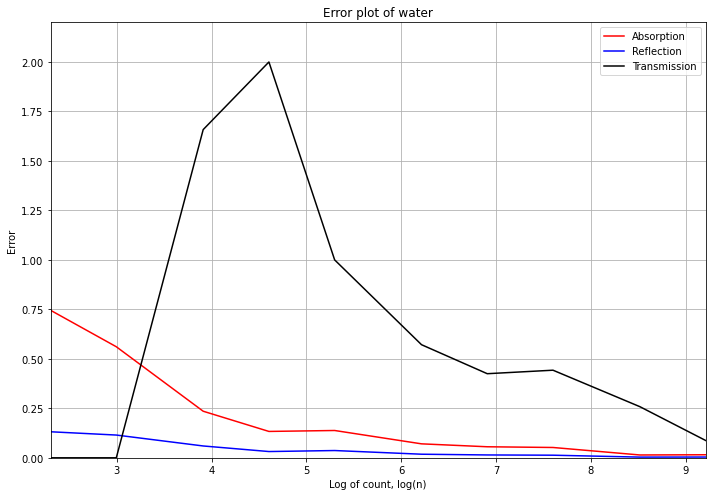

In [27]:
plot_error_for_count(water)

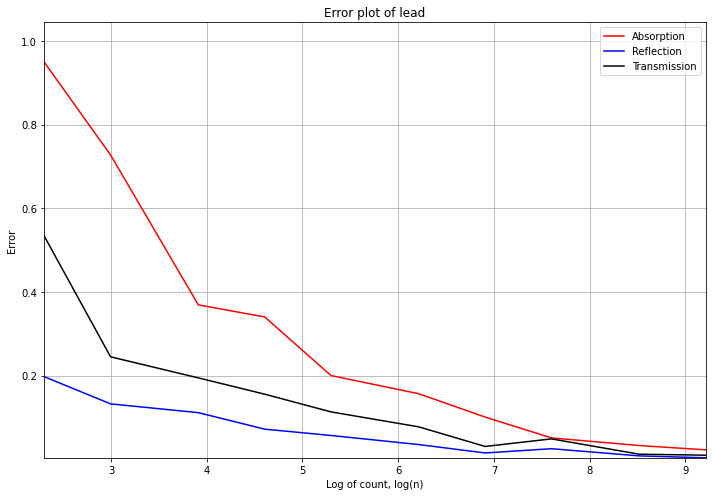

In [28]:
plot_error_for_count(lead)

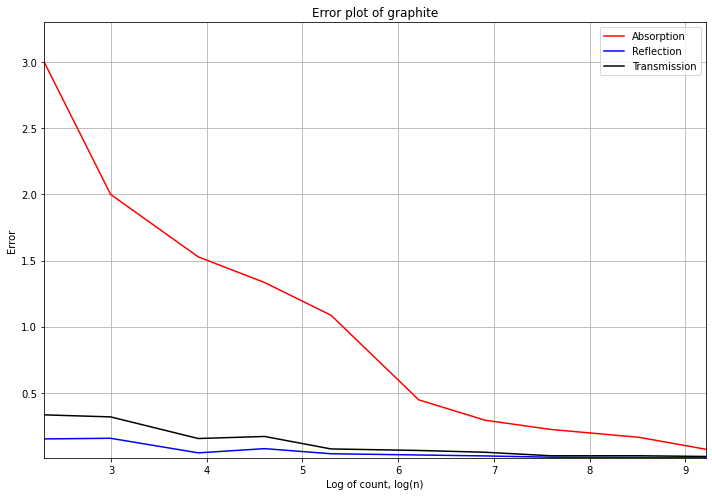

In [29]:
plot_error_for_count(graphite)

As seen from all the graphs that as the count rate increases, the error in the results reduces. So it is important when running the simulation to have a high count rate, like 10000 which is used in this section.

# Transmission rate as a function of thickness

It is expected, that as the thickness of material increases, the rate of transmission of neutrons will decrease. The rate at which this decreases can be used to determine the characteristic attenuation length of each material.

Below is plotted the ratio of transmission for 10 different lengths for each material, then taking the log of these results a relationship can be determined for ratio and transmission and thickness. However, this relationship, as seen, is not always linear, so the characteristic attenuation length of some materials is a function of thickness itself.

In [36]:
def transmisson_ratio(count, material, max_T):
    
    #Sets the range of thickness the ratio of transmission the results will be calculated for and creates an empty
    #array for the results to be stored
    
    thickness = np.arange(1, max_T+1, max_T / 10)
    results = np.empty((0, 3))
    
    #Iterates through each thickness calculating the mean percentage and standard deviation of the transmission rate
    #for the given material and count rate.
    
    for T in thickness:
        
        thickness_ratios = ratio_calculator(count, material, T)
        temp = np.hstack((T, thickness_ratios[0][2], thickness_ratios[1][2]))
        results = np.vstack((results, temp))
        
    #Logs the rate of transmission and calculates the percentage error on the transmission rate which is equal
    #to the uncertainty of the log rate.
    
    results = np.delete(results, np.where(results[:, 1] == 0), axis=1)
    log_ratio = np.log(results[:, 1])
    
    #Performs a polyfit, as done in the previous section above, to calculate the linear relationship between
    #the log of the count rate versus the thickness, again giving more weight to points will a smaller error.
       
    coeff, covariance = np.polyfit(thickness, log_ratio, 1, w=1/results[:, 2], cov=True)
    
    return results, log_ratio, coeff, covariance

In [37]:
def ratio_for_transmission_plotter(count, material, max_T):
    
    results, log_ratio, coeff, covariance = transmisson_ratio(count, material, max_T)

    #Plots a scatter graph and a graph of the log of the ratio versus thickness, this second graph can be used to
    #calulate the characteristic attenuation lengths for some materials like water.
        
    fig = plt.figure(figsize=(10, 7))
    
    scatter_ax = fig.add_subplot(211)
    log_ax = fig.add_subplot(212)

    scatter_ax.errorbar(results[:, 0], results[:, 1], results[:, 2], color='k', fmt='_')
    scatter_ax.plot(results[:, 0], np.exp(results[:, 0]*coeff[0]+coeff[1]), color='r')
    scatter_ax.grid()
    scatter_ax.set_title("Ratio of transmission for "+material["name"])
    scatter_ax.set_xlabel("Thickness, T (cm)")
    scatter_ax.set_ylabel("Ratio")
    scatter_ax.set_xlim(1, np.max(results[:, 0]))
    scatter_ax.set_ylim(0, np.max(results[:, 1])*1.1)
    
    log_ax.errorbar(results[:, 0], log_ratio, results[:, 2], color='k', fmt='_')
    log_ax.plot(results[:, 0], results[:, 0]*coeff[0]+coeff[1], color='r')
    log_ax.grid()
    log_ax.set_title("Log ratio of transmission for "+material["name"])
    log_ax.set_xlabel("Thickness, T (cm)")
    log_ax.set_ylabel("Log of ratio")
    log_ax.set_xlim(1, np.max(results[:, 0]))
    
    plt.tight_layout()
    plt.show()
    
    #Outputs the characteristic attenuation lengths with uncertainty.
    
    lambda_cal = -1 / coeff[0]
    lambda_cal_std = abs(np.sqrt(covariance[0][0])) * lambda_cal
    
    print("Characteristic attenuation length = {0:3.2f} ± {1:1.2f} cm".format(lambda_cal, lambda_cal_std))

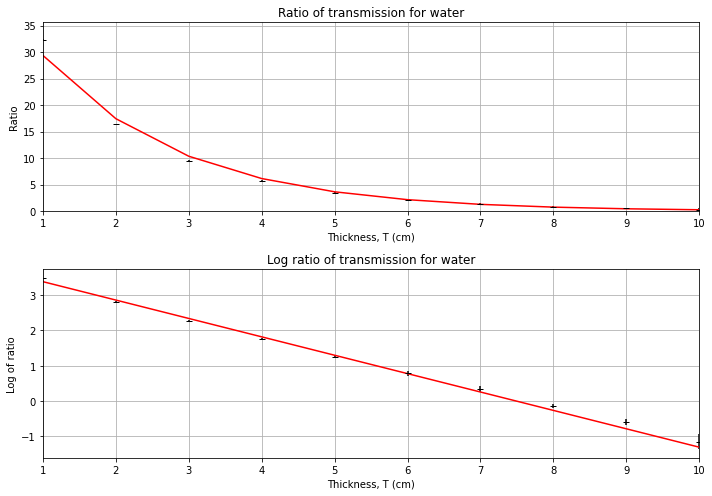

Characteristic attenuation length = 1.92 ± 0.03 cm


In [38]:
ratio_for_transmission_plotter(10000, water, 10)

From the plot of the ratio of transmission and thickness for water, it can be seen, by taking the logarithm of the ratio, that there is a linear relationship between thickness and the log ratio. A line of best fit is plotted on the log graph using a relationship found by polyfit, this used the same method as in the section above. Also, a line of best fit is plotted on the transmission graph, by taking the exponential of this linear fit.

The characteristic attenuation length was found to be 1.81 ± 0.03 cm.

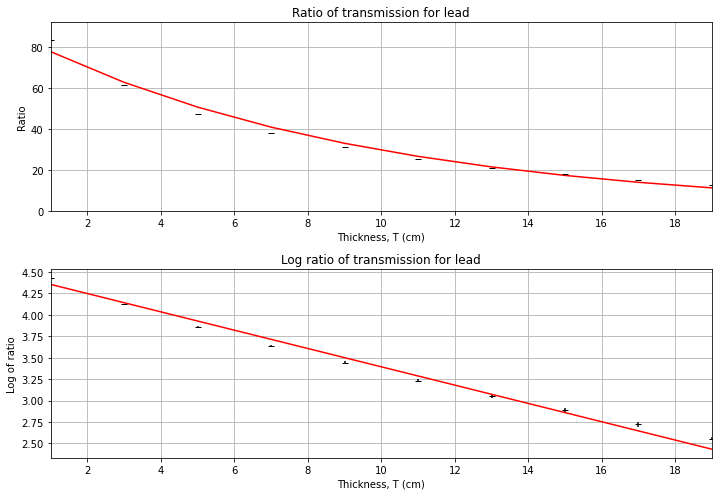

Characteristic attenuation length = 9.36 ± 0.04 cm


In [36]:
ratio_for_transmission_plotter(10000, lead, 20)

From the plot of the ratio of transmission and thickness for lead, it can be seen, by taking the logarithm of the ratio, that there is a close to a linear relationship between thickness and the log ratio. A line of best fit is plotted on both graphs using the same method discussed.

The characteristic attenuation length of lead was found to be 8.83 ± 0.04 cm, however, as the relationship is not truly linear the results found might vary depending on the thickness chosen as the gradient is not constant.

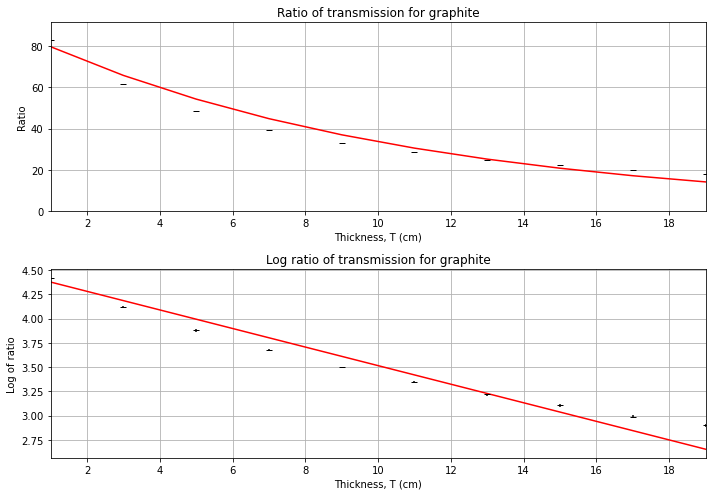

Characteristic attenuation length = 10.43 ± 0.06 cm


In [39]:
ratio_for_transmission_plotter(10000, graphite, 20)

From the plot of the ratio of transmission and thickness for graphite, it can be seen, by taking the logarithm of the ratio, that the relationship is not linear. This means that the attenuation length is a function of thickness. A line of best fit is plotted on both graphs, however, this is based on a linear relationship and it can be seen that it is inconsistent with the data.

The characteristic attenuation length of graphite was found to be 10.63 ± 0.06 cm, however, as the relationship is not linear the results found might vary depending on the thickness chosen as the gradient is not constant.

# Woodcock method

In this section, the woodcock method is used to simulate what would happen to neutrons travelling through two materials that are touching. This is done by assuming that as particles travel through either material, they travel will the minimum mean free path of the two materials, thereby taking smaller steps. However, if the particle is in the material with the larger mean free path, there is a chance for the particle to take a fictitious step. A fictitious step is a step in which the direction of the particle does not change and neither scattering nor absorption takes place, thereby simulating one large step as many small fictitious steps.

In [41]:
def length(count, lambda_t):
    
    #Generates an array of uniformly random numbers between 0 and 1, then this random number is logarithmically distributed
    #using the total mean free path for the given material.
    
    array = random(count)
    s_i = - lambda_t * np.log(array)
    
    return s_i

In [42]:
def length_with_direction(count, lambda_t):
    
    #Generates an array of uniformly random numbers between 0 and 1, then this random number is logarithmically distributed
    #using the total mean free path for the given material.
    
    array = random(count)
    s_i = - lambda_t * np.log(array)
    
    #Uses the method discussed in the previous section to calculate two random theta and phi angles
       
    theta_angles = np.arccos(1 - 2 * random(count))
    phi_angles = np.random.uniform(0, 2*np.pi, count)
    
    #Return the length distribution and angle of direction.

    return np.hstack((s_i.reshape(-1, 1), (np.sin(theta_angles) * np.cos(phi_angles)).reshape(-1, 1)))

In [43]:
def woodcock_track(count, material_1, material_2, T_1, T_2):
    
    #Calculates the total mean free path ,by taking the minimum mean free path of the two materials; the ficticous probability,
    #this will be used to determine whether a particle in material 1 will take a ficitious step or not and the
    #probability of absorption for each materials. It makes exceptions for a vacuum where the calulations would
    #produce a ZeroDivisionError, instead it calculates the mean free path to be the minimum free path as before
    #and the probability of ficitious to be 1 and absorption to be 0.
    
    if material_1["molar_mass"] != 0:
        lambda_array = (material_properties(material_1)[0], material_properties(material_2)[0])
        lambda_t = np.min(lambda_array)
        ficticious_probability = 1 - (lambda_t / lambda_array[0])

        P_A = ([material_properties(material_1)[1], material_properties(material_2)[1]])
        
    else:
        lambda_t = material_properties(material_2)[0]
        ficticious_probability = 1
        
        P_A = ([0, material_properties(material_2)[1]])
        
    #Calulates the total thickness of the two materials.
    
    T = T_1 + T_2

    #Defines arrays that will store the position of each neutron, the length distrubtion based on a random
    #number, the direction the particle will travel, a true array on whether the step is ficitious or not
    #and the probability of absorption which is set depending on which material the particle is in.
    
    start_position = np.zeros(count).reshape(-1, 1)                       #Index 0
    s_i_array = random(count).reshape(-1, 1)                              #Index 1
    direction_array = np.linspace(1, 1, count).reshape(-1, 1)             #Index 2
    is_fictious = (random(count) < ficticious_probability).reshape(-1, 1) #Index 3
    P_A_array = np.linspace(P_A[0], P_A[0], count).reshape(-1, 1)         #Index 4

    #Stacks the arrays into a 2D array and calulates the position of the first step of the neutron.
    
    neutrons_path = np.hstack((start_position, s_i_array, direction_array, is_fictious, P_A_array))
    neutrons_path[:, 0] = - lambda_t * np.log(neutrons_path[:, 1])
    
    #Creates varibles to sort the count of each process.
    
    transmitted_count, reflected_count, absorbed_count = 0, 0, 0
    
    #Loops through each step and process until there are no neutrons left in the system.
    
    while len(neutrons_path) > 0:
        
        #Counts how many of the positions are either greater than the thickness T, transmission, or less than 0,
        #reflection. Then it deletes them from the arry as their neutrons_position have been terminated.        
        
        transmitted_count += np.count_nonzero(neutrons_path[:, 0] > T)
        reflected_count += np.count_nonzero(neutrons_path[:, 0] < 0)
        neutrons_path = np.delete(neutrons_path, np.where((neutrons_path[:, 0] < 0) | (neutrons_path[:, 0] > T))[0], axis=0)
        
        #Creates an array of uniformly random numbers between 0 and 1, the array is the size of the array holding
        #the neutrons neutrons_position. If the number is less then the probabitly of absorption it is counted and 
        #then deleted from the array, the probility of absorption depends on the material the particle is in.
        
        neutrons_path[np.where(neutrons_path[:, 0] > T_1), 4] = P_A[1]
        neutrons_path[np.where(neutrons_path[:, 0] < T_1), 4] = P_A[0]
        
        absorbed_index = np.where((random(len(neutrons_path)) < neutrons_path[:, 4]) & (neutrons_path[:, 3]==False))[0]
        absorbed_count += len(absorbed_index)
        
        neutrons_path = np.delete(neutrons_path, absorbed_index, axis=0)
        
        #Checks if the neutrons next step is fictious or not.
        
        neutrons_path[:, 3] = ((neutrons_path[:, 0] < T_1) & (random(len(neutrons_path)) < ficticious_probability))
        
        #Calulates the position of the particle, if the particle is not fictious the position is determined using 
        #a new length distrubtion and new angle calulated using random numbers, if the particle is ficitous only 
        #a new length is used the angle of the previous step is kept the same.
        
        not_fictious = np.where(neutrons_path[:, 3]==False)[0]
        neutrons_path[not_fictious, 1:3] = length_with_direction(len(not_fictious), lambda_t)
        
        is_fictious = np.where(neutrons_path[:, 3]==True)[0]
        neutrons_path[is_fictious, 1] = length(len(is_fictious), lambda_t)
        
        neutrons_path[:, 0] += np.prod(neutrons_path[:, 1:3], axis=1)
        
    return absorbed_count, reflected_count, transmitted_count

In [45]:
def ratio_calculator_woodcock(count, material_1, material_2, T_1, T_2):
    
    #Sets the number of times to repeat the calculations and creates an empty array for the results to be stored.
    
    repeats = 10
    results = np.empty((0, 3))
    
    #Repeats the calculation for the given system, storing the results in the results array.
    
    for i in range(repeats):
    
        results_for_repeat = woodcock_track(count, material_1, material_2, T_1, T_2)        
        results = np.vstack((results, results_for_repeat))
        
    #Calculates the mean and error of the results for the repeats
        
    results_mean, results_std  = (np.mean(results, axis=0) / count) * 100, (np.std(results, axis=0) / count) * 100    
    results_error = np.empty(0)
    
    for iterations, mean in enumerate(results_mean):
        
        if mean == 0:
            results_error = np.hstack((results_error, results_std[iterations] / np.max(results[iterations])))
           
        else:
            results_error = np.hstack((results_error, results_std[iterations] / mean))
    
    return results_mean, results_error

In [46]:
def results_woodcock(count, material_1, material_2, T_1, T_2):
    
    #Outputs the mean percentage and error of absorption, transmission and reflection for the materials.
    
    results_mean, results_std = ratio_calculator_woodcock(count, material_1, material_2, T_1, T_2)
    
    print("-"*57, "\nTransmission Through A Fixed Thickness -", material_1["name"], "and", material_2["name"],  "\n", "-"*55)
    print("Thickness: \t\t {0:.2f} cm and {1:.2f} cm".format(T_1, T_2))
    print("Total Neutrons: \t", count)
    print("Neutrons Absorbed: \t {0:.2f} % ± {1:.2f} %".format(results_mean[0], results_std[0]))
    print("Neutrons Reflected: \t {0:.2f} % ± {1:.3f} %".format(results_mean[1], results_std[1]))
    print("Neutrons Transmitted: \t {0:.2f} % ± {1:.2f} %".format(results_mean[2], results_std[2]))

To test whether this simulation is correct or not, two cases are taken. The first is that of a vacuum with water, because a vacuum has an infinite mean free path, the particle will always take a fictitious step in the vacuum and thereby all real steps occur in water. This means we could expect the results to be the same as in the previous section for just water.
The second case is that of a very thin layer of a material, lead or graphite and then a layer of water. As the first layer is very thin, it can be assumed that the neutrons spend nearly all their time in the water. Again, this means the results should be the same as in the previous sections.

Simulating neutrons travelling through two layers, the first 10 cm of vacuum and the second 10 cm of water.

In [47]:
count = 10000
material_1 = vacuum
material_2 = water
thickness_1 = 10 #cm
thickness_2 = 10 #cm

results_woodcock(count, material_1, material_2, thickness_1, thickness_2)

--------------------------------------------------------- 
Transmission Through A Fixed Thickness - vacuum and water 
 -------------------------------------------------------
Thickness: 		 10.00 cm and 10.00 cm
Total Neutrons: 	 10000
Neutrons Absorbed: 	 19.51 % ± 0.03 %
Neutrons Reflected: 	 80.19 % ± 0.007 %
Neutrons Transmitted: 	 0.30 % ± 0.21 %


The results are similar to the results calculated in the section above for 10 cm of water.

Simulating neutrons travelling through two layers, the first 0.01 cm of lead and the second 10 cm of water.

In [48]:
count = 10000
material_1 = lead
material_2 = water
thickness_1 = 0.01 #cm
thickness_2 = 10 #cm

results_woodcock(count, material_1, material_2, thickness_1, thickness_2)

--------------------------------------------------------- 
Transmission Through A Fixed Thickness - lead and water 
 -------------------------------------------------------
Thickness: 		 0.01 cm and 10.00 cm
Total Neutrons: 	 10000
Neutrons Absorbed: 	 19.70 % ± 0.01 %
Neutrons Reflected: 	 79.98 % ± 0.003 %
Neutrons Transmitted: 	 0.32 % ± 0.13 %


The results are similar to the results calculated in the section above for 10 cm of water.

Simulating neutrons travelling through two layers, the first 10 cm of lead and the second 10 cm of water.

In [49]:
count = 10000
material_1 = lead
material_2 = water
thickness_1 = 10 #cm
thickness_2 = 10 #cm

results_woodcock(count, material_1, material_2, thickness_1, thickness_2)

--------------------------------------------------------- 
Transmission Through A Fixed Thickness - lead and water 
 -------------------------------------------------------
Thickness: 		 10.00 cm and 10.00 cm
Total Neutrons: 	 10000
Neutrons Absorbed: 	 26.53 % ± 0.01 %
Neutrons Reflected: 	 73.29 % ± 0.005 %
Neutrons Transmitted: 	 0.18 % ± 0.30 %


Simulating neutrons travelling through two layers, the first 10 cm of graphite and the second 10 cm of water.

In [50]:
count = 10000
material_1 = graphite
material_2 = water
thickness_1 = 10 #cm
thickness_2 = 10 #cm

results_woodcock(count, material_1, material_2, thickness_1, thickness_2)

--------------------------------------------------------- 
Transmission Through A Fixed Thickness - graphite and water 
 -------------------------------------------------------
Thickness: 		 10.00 cm and 10.00 cm
Total Neutrons: 	 10000
Neutrons Absorbed: 	 14.71 % ± 0.03 %
Neutrons Reflected: 	 85.08 % ± 0.005 %
Neutrons Transmitted: 	 0.21 % ± 0.23 %


Simulating neutrons travelling through two layers, the first 10 cm of lead and the second 10 cm of graphite.

In [51]:
count = 10000
material_1 = lead
material_2 = graphite
thickness_1 = 10 #cm
thickness_2 = 10 #cm

results_woodcock(count, material_1, material_2, thickness_1, thickness_2)

--------------------------------------------------------- 
Transmission Through A Fixed Thickness - lead and graphite 
 -------------------------------------------------------
Thickness: 		 10.00 cm and 10.00 cm
Total Neutrons: 	 10000
Neutrons Absorbed: 	 14.57 % ± 0.03 %
Neutrons Reflected: 	 71.22 % ± 0.006 %
Neutrons Transmitted: 	 14.21 % ± 0.02 %
